In [29]:

# from pyspark.ml import Pipeline
# from pyspark.sql.window import Window
# from pyspark.ml.feature import OneHotEncoder

# from transactions_transformer import TransactionsTransformer

In [5]:
from pyspark.sql import SparkSession
from transactions_aggregator import TransactionsAggregator
from pyspark.ml.regression import LinearRegression
from pipeline_builder import PipelineBuilder
from pyspark.ml.evaluation import RegressionEvaluator

spark_session = SparkSession.builder.master("local[2]").appName("T2F").getOrCreate()
transactions = spark_session.read.csv('transactions.csv', header=True, inferSchema=True) 

item=19068
cross_items=[10628, 24458]
memory=2

transactions_aggregator = TransactionsAggregator(spark_session, transactions, item, cross_items)
transactions_agg = transactions_aggregator.aggregate()

# Train test split.
train_df, test_df = transactions_agg.randomSplit([0.8, 0.2])

linear_regression = LinearRegression(maxIter=5, regParam=0.0, solver="normal")

# Create pipeline.
pipeline_builder = PipelineBuilder(spark_session, linear_regression, item, cross_items, memory)
pipeline = pipeline_builder.build()
model = pipeline.fit(train_df)

# Coefficients and intercept.
print('Coefficients:\n\n{}\n\nIntercept:\n\n{}'.format(model.stages[-1].coefficients, model.stages[-1].intercept))

# df = transactions_agg
# df = pipeline.stages[0].transform(df)
# df = model.stages[1].transform(df)
# df = model.stages[2].transform(df)
# df = model.stages[3].transform(df)
# df = model.stages[4].transform(df)
# df = model.stages[5].transform(df)
# df = model.stages[6].transform(df)
# df = model.stages[7].transform(df)
# df.show(5, truncate=False)

Coefficients:

[0.168701888804401,0.0,-0.1961042317108752,-0.2527039783272279,0.09323638061917162,-0.3923554058532904,-0.12368231650622638,0.20355730643920447,-0.4046289816118027,-0.0288380137908358,-0.13336949078645527,-0.02775170127924546,-0.19349677273486698,-0.3587641036942868,0.002370707510701939,-2.6837109811570725,-5.1116652745867475]

Intercept:

30.05026625194099


In [7]:
print(str.format('{0:.30f}', model.stages[-1].coefficients[1]))

0.000000000000000000000000000000


In [11]:
len(model.stages[-1].coefficients)

17

In [2]:
df = transactions_agg
df = model.stages[0].transform(df)
df = model.stages[1].transform(df)
df = model.stages[2].transform(df)
df = model.stages[3].transform(df)
df = model.stages[4].transform(df)
df = model.stages[5].transform(df)
df = model.stages[6].transform(df)
df = model.stages[7].transform(df)
df.show(100, truncate=False)

+----+----+-----+------------------+------------------+------------+------------------+------------------+------------------+---------------+---------------------+---------------------+---------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------+------------------+
|year|week|month|cost_19068        |price_19068       |demand_19068|cross_price_10628 |cross_price_24458 |log_price_19068   |month_encoded  |log_price_19068_lag_1|log_price_19068_lag_2|log_cross_price_10628|log_cross_price_24458|features                                                                                                                    |log_demand_19068  |
+----+----+-----+------------------+------------------+------------+------------------+------------------+------------------+---------------+---------------------+---------------------+---------------------+---------------------+-----------------------

In [30]:




# Read in and transform transactions.
t2f = TransactionsToFeatures('transactions.csv', item=19068, cross_items=[10628, 24458], memory=2)
features_df = t2f.fit_transform()

# # Train test split.
# train_df, test_df = features_df.randomSplit([0.8, 0.2])

# Create pipeline.
linear_regression = LinearRegression(predictionCol="prediction", maxIter=5, regParam=0.0, solver="normal")
pipeline = create_pipeline(linear_regression)
model = pipeline.fit(train_df)

# Coefficients and intercept.
print('Coefficients:\n\n{}\n\nIntercept:\n\n{}'.format(model.stages[-1].coefficients, model.stages[-1].intercept))

Coefficients:

[0.0,-0.9856039198695629,-0.7158129364518336,-0.22942173686492204,-0.631184208891067,-0.4091050777042303,-0.19378249911465054,-0.8128368097719274,-0.29968183332365744,-0.5168268897318176,-0.03846579698866657,-0.38215759941320887,-1.2561057032959941,0.4307079365321069,0.2992772313993132,-0.2116727990272731,-5.2285245893707195]

Intercept:

29.968470118747746


In [33]:
# Train and test RMSE.
train_df = model.transform(train_df)
test_df = model.transform(test_df)
regression_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='log_demand_{}'.format(item))
train_err = regression_evaluator.evaluate(train_df)
test_err = regression_evaluator.evaluate(test_df)
print('Train RMSE:\n\n{}\n\nTest RMSE:\n\n{}'.format(train_err, test_err))

Train RMSE:

0.5791669788786485

Test RMSE:

0.7433547970135496


In [1]:
import csv

from iowa_liquor_sales_service import IowaLiquorSalesService

from pyspark.sql.types import *

In [2]:
iowaLiquorSalesService = IowaLiquorSalesService()

In [3]:
iowaLiquorSalesService.query('''
SELECT
    COUNT(itemno)
WHERE
    vendor_no='65' AND
    itemno IN ('19068','10628','24458')
''')

[['COUNT_itemno'], ['59468']]

In [4]:
transactions_list = iowaLiquorSalesService.query('''
SELECT
    invoice_line_no, 
    date, 
    category, 
    category_name, 
    vendor_no, 
    vendor_name, 
    itemno AS item, 
    im_desc, 
    state_bottle_cost AS cost, 
    state_bottle_retail AS price, 
    sale_bottles AS sales, 
    sale_dollars
WHERE
    vendor_no='65' AND
    itemno IN ('19068','10628','24458')
LIMIT 60000
''')

In [5]:
with open("transactions.csv", "w") as transactions_csv:
    writer = csv.writer(transactions_csv)
    writer.writerows(transactions_list)

In [72]:
t2f = TransactionsToFeatures('transactions.csv', item=19068, cross_items=[10628, 24458], memory=2)
prices_df = t2f.create_prices_df()
prices_df.show(1000)

+-------------------+----+-----+----+----------+-----------+-----------+
|               date|year|month|week|cost_19068|price_19068|sales_19068|
+-------------------+----+-----+----+----------+-----------+-----------+
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|
|2014-01-22 00:00:00|2014|    1|   4|     19.94|      29.91|          2|
|2015-07-16 00:00:00|2015|    7|  29|     20.99|      31.49|          6|
|2013-01-21 00:00:00|2013|    1|   4|     19.42|      29.14|          6|
|2013-10-30 00:00:00|2013|   10|  44|     18.42|      28.14|          2|
|2012-06-12 00:00:00|2012|    6|  24|     18.37|      27.55|          6|
|2015-10-28 00:00:00|2015|   10|  44|     19.99|      30.49|          6|
|2015-11-09 00:00:00|2015|   11|  46|     20.99|      31.49|          2|
|2015-11-16 00:00:00|2015|   11|  47|     20.99|      31.49|          6|
|2013-11-11 00:00:00|2013|   11|  46|     19.94|      29.91|          6|
|2013-11-26 00:00:00|2013|   11|  48|     19.94|   

In [69]:
cross_prices_df = t2f.create_cross_prices_df(10628)
cross_prices_df.show(5)

+-------------------+-----------------+
|               date|cross_price_10628|
+-------------------+-----------------+
|2013-02-04 00:00:00|            23.62|
|2013-11-19 00:00:00|            23.62|
|2012-08-28 00:00:00|            23.62|
|2015-08-11 00:00:00|            23.63|
|2015-04-07 00:00:00|            23.63|
+-------------------+-----------------+
only showing top 5 rows



In [71]:
prices_and_cross_prices_df = t2f.select_all_left_join_on_date(prices_df, cross_prices_df)
prices_and_cross_prices_df.show(1000)

+-------------------+----+-----+----+----------+-----------+-----------+-----------------+
|               date|year|month|week|cost_19068|price_19068|sales_19068|cross_price_10628|
+-------------------+----+-----+----+----------+-----------+-----------+-----------------+
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|

In [59]:
spark_session = SparkSession.builder.master("local[2]").appName("T2F").getOrCreate()


features_df = spark_session.sql('''

        SELECT 
            prices.date, 
            prices.year,
            prices.month,
            prices.week,
            prices.cost_19068, 
            prices.price_19068, 
            prices.sales_19068,
            cross_prices.cross_price_10628
        FROM 
            (

                    
                SELECT
                    date,
                    YEAR(date) AS year,
                    MONTH(date) AS month,
                    WEEKOFYEAR(date) AS week,
                    cost AS cost_19068, 
                    price AS price_19068, 
                    sales AS sales_19068
                FROM 
                    transactions
                WHERE
                    item='19068'
                    
            ) AS prices
        LEFT JOIN 
            (
                SELECT
                    date, 
                    price AS cross_price_10628
                FROM 
                    transactions
                WHERE
                    item='10628'
                

            ) AS cross_prices 
        ON 
            prices.date=cross_prices.date

''')
features_df.show(1000)

+-------------------+----+-----+----+----------+-----------+-----------+-----------------+
|               date|year|month|week|cost_19068|price_19068|sales_19068|cross_price_10628|
+-------------------+----+-----+----+----------+-----------+-----------+-----------------+
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|
|2014-05-13 00:00:00|2014|    5|  20|     19.94|      29.91|          6|            23.62|

In [24]:
from pyspark.ml.feature import OneHotEncoder
from log_feature import LogFeature
from lag_feature import LagFeature
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [34]:
train_df.show(5)

+----+----+-----+------------------+------------------+------------+------------------+------------------+--------------+------------------+---------------------+---------------------+---------------------+---------------------+--------------------+------------------+------------------+
|year|week|month|        cost_19068|       price_19068|demand_19068| cross_price_10628| cross_price_24458| month_encoded|   log_price_19068|log_price_19068_lag_1|log_price_19068_lag_2|log_cross_price_10628|log_cross_price_24458|            features|  log_demand_19068|        prediction|
+----+----+-----+------------------+------------------+------------+------------------+------------------+--------------+------------------+---------------------+---------------------+---------------------+---------------------+--------------------+------------------+------------------+
|2012|   1|    1| 18.77479590122578|28.162976650428863|      136797|23.619999999997148|16.519999999998817|(12,[1],[1.0])|3.3380082306192

In [ ]:
5730|2012|    1|   1

In [38]:
import numpy as np
np.exp(11.826253354105564)

136797.00000000003

In [37]:
np.log(389677.99999999965)

12.87307603605091

In [13]:
model.stages

[OneHotEncoder_4c6d856f1e8166febb10,
 LogFeature_4ed197a57b4eeffad066,
 LagFeature_47e68296ca6c983ae269,
 LagFeature_47c4beec5167f4345078,
 LogFeature_4945aa8bc24cef361afe,
 LogFeature_46ac8734fa943b4e0616,
 VectorAssembler_4580b31ee3fae8e8ae9a,
 LogFeature_460c99343709e744394b,
 LinearRegression_42189483c6b50ae45696]

In [16]:
t2f = TransactionsToFeatures('transactions.csv', item=19068, cross_items=[10628, 24458], memory=2)
df = t2f.fit_transform()
df = model.stages[0].transform(df)
df = model.stages[1].transform(df)
df = model.stages[2].transform(df)
df = model.stages[3].transform(df)
df = model.stages[4].transform(df)
df = model.stages[5].transform(df)
df = model.stages[6].transform(df)
df = model.stages[7].transform(df)
df.show(5, truncate=False)

+----+----+-----+------------------+------------------+------------+------------------+------------------+--------------+------------------+---------------------+---------------------+---------------------+---------------------+---------------------------------------------------------------------------------------------------------------------------+------------------+
|year|week|month|cost_19068        |price_19068       |demand_19068|cross_price_10628 |cross_price_24458 |month_encoded |log_price_19068   |log_price_19068_lag_1|log_price_19068_lag_2|log_cross_price_10628|log_cross_price_24458|features                                                                                                                   |log_demand_19068  |
+----+----+-----+------------------+------------------+------------+------------------+------------------+--------------+------------------+---------------------+---------------------+---------------------+---------------------+----------------------------

In [144]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="log_demand_19068", predictionCol="prediction", maxIter=5, regParam=0.0, solver="normal")
model = lr.fit(train_df)

In [145]:
print(model.coefficients)

[0.0,-0.5117965533723511,-0.4066275879243095,0.0052448365229987946,-0.4049514331857193,-0.22576401051489872,0.19208238926697682,-0.6959433189978355,-0.1137797890482209,-0.34718082201845163,0.09067917016317777,-0.27040050294731344,0.986820285556437,0.4494011961323097,-0.49235654588628186,-2.008956549884303,-4.875587889348174]


In [146]:
len(model.coefficients)

17

In [147]:
print(model.intercept)

29.425696348107575


In [148]:
train_df = model.transform(train_df)
test_df = model.transform(test_df)

In [151]:
from pyspark.ml.evaluation import RegressionEvaluator

regression_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='log_demand_19068')

train_err = regression_evaluator.evaluate(train_df)
test_err = regression_evaluator.evaluate(test_df)

print('Training rmse is {},\nTest rmse is {}'.format(train_err, test_err))

Training rmse is 0.6224338392747611,
Test rmse is 0.5818592277598783


In [153]:
import numpy as np
np.exp(0.5818592277598783)

1.7893621718191255

In [154]:
test_df.show(5)

+----+----+-----+------------------+------------------+------------+------------------+------------------+------------------+------------------+---------------------+---------------------+---------------------+---------------------+--------------+--------------------+------------------+
|year|week|month|        cost_19068|       price_19068|demand_19068| cross_price_10628| cross_price_24458|   log_price_19068|  log_demand_19068|log_cross_price_10628|log_cross_price_24458|log_price_19068_lag_1|log_price_19068_lag_2| month_encoded|            features|        prediction|
+----+----+-----+------------------+------------------+------------+------------------+------------------+------------------+------------------+---------------------+---------------------+---------------------+---------------------+--------------+--------------------+------------------+
|2012|   7|    2|18.369999999996942| 27.54999999999339|      141933| 22.61999999999664| 16.51999999999675|3.3160025355986837|11.86311039

In [156]:
pandas_test_df = test_df.toPandas()

In [172]:
import numpy as np
# Import matplotlib modules.
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 20.0,
    'axes.titlesize': 'small',
    'axes.labelsize': 'small',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small'
})


def acc_res_plots(y_true, y_pred):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 16))
    # Accuracy plot.
    ax[0].scatter(y_pred, y_true);
    ax[0].set_title('Accuracy')  
    ax[0].set_ylabel('Actual')
    # Residual plot.
    residuals = y_true - y_pred
    ax[1].scatter(y_pred, residuals);
    ax[1].set_title('Residuals')  
    ax[1].set_ylabel('Residual')
    ax[1].set_xlabel('Predicted')
    # Plot model.
    pred_min = np.amin(y_pred)
    pred_max = np.amax(y_pred)
    ax[0].plot([pred_min, pred_max], [pred_min, pred_max], 'k--')
    ax[1].plot([pred_min, pred_max], [0, 0], 'k--')
    fig.tight_layout()
    return (fig, ax)


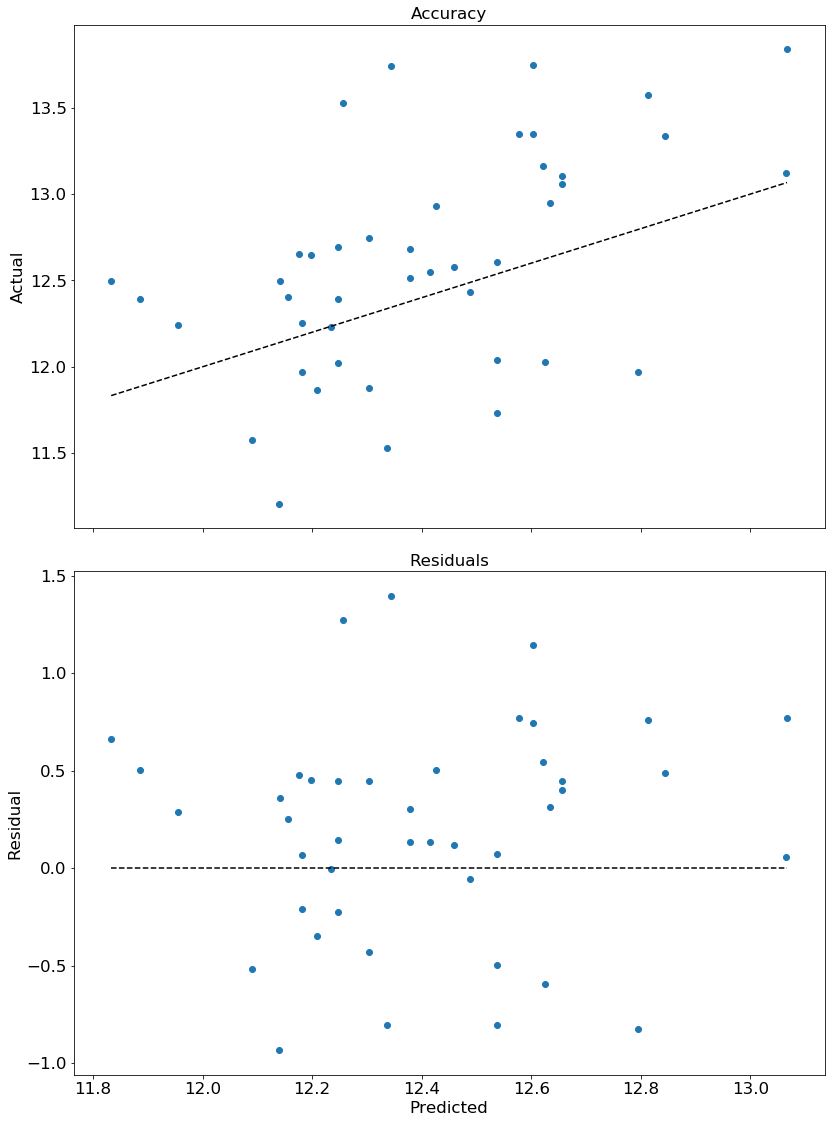

In [173]:
acc_res_plots(pandas_test_df['log_demand_19068'].values, pandas_test_df['prediction'].values);

In [162]:
pandas_test_df['prediction'].values

array([12.2093882 , 12.30334564, 11.83316633, 12.41532986, 12.18192883,
       12.18192883, 13.06548844, 13.06707662, 12.17544163, 12.53716156,
       11.8861259 , 12.23488839, 12.3359556 , 12.19710821, 12.5768842 ,
       12.37797178, 12.37797178, 12.79581818, 12.48910565, 12.25570462,
       12.45902894, 12.60288544, 12.60288544, 12.09108889, 12.62487182,
       12.63503427, 12.2465215 , 12.8130956 , 12.53769314, 12.30429211,
       12.34331294, 12.62101321, 12.1410626 , 12.15556535, 12.13967638,
       12.65671777, 12.65671777, 12.2465215 , 12.2465215 , 12.42570892,
       12.84355532, 11.95552961, 12.53769314])

In [28]:
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

Column<b'LOG(price_19068)'>

In [44]:
prices_df.join(cross_prices_df, prices_df("date") == cross_prices_df("date"), "left_outer")

TypeError: 'DataFrame' object is not callable

In [98]:
spark_session = SparkSession.builder.master("local[2]").appName("T2F").getOrCreate()


features_df = spark_session.sql('''
SELECT
    MAX(item) AS item,
    SUM(sales) AS demand,
    YEAR(date) AS year,
    MIN(MONTH(date)) AS month,
    WEEKOFYEAR(date) AS week,
    AVG(cost) AS cost,
    AVG(price) AS price,
    AVG(cross_price) AS cross_price
FROM
    (
        SELECT 
            prices.item,
            prices.date, 
            prices.cost, 
            prices.price, 
            prices.sales,
            cross_prices.price AS cross_price
        FROM 
            (
                SELECT
                    item,
                    date, 
                    cost, 
                    price, 
                    sales
                FROM 
                    transactions
                WHERE
                    item='19068'
            ) AS prices
        LEFT JOIN 
            (
                SELECT
                    date, 
                    price
                FROM 
                    transactions
                WHERE
                    item='10628'
            ) AS cross_prices 
        ON 
            prices.date=cross_prices.date
    )
GROUP BY year, week
ORDER BY year, week ASC
''')
features_df.show(1000)

+-----+------------------+----+-----+----+------------------+------------------+------------------+
| item|            demand|year|month|week|              cost|             price|       cross_price|
+-----+------------------+----+-----+----+------------------+------------------+------------------+
|19068| 7.047970479704797|2012|    1|   1|18.699335793357932|28.048708487084784| 23.62000000000007|
|19068| 6.174870466321243|2012|    1|   2| 18.36999999999991|27.549999999999933|             23.62|
|19068| 17.95045045045045|2012|    1|   3|18.370000000000097| 27.54999999999973|23.620000000000243|
|19068| 11.86323268206039|2012|    1|   4|18.370000000000093|27.549999999999724| 23.62000000000025|
|19068| 5.904076738609112|2012|    1|   5|18.370000000000164|27.549999999999677|23.170759392486303|
|19068|7.1019736842105265|2012|    2|   6|18.370000000000147| 27.54999999999969|22.620000000000267|
|19068| 5.510938602681722|2012|    2|   7|18.370000000000235|27.549999999999635|22.620000000000346|


In [83]:
# spark_session = SparkSession.builder.master("local[2]").appName("T2F").getOrCreate()


# Return month-level demand and average price.
def month_level_data():
    return spark_session.sql('''
        SELECT 
            SUM(sale_bottles) AS demand, 
            YEAR(date) AS year, 
            MONTH(date) AS month, 
            AVG(state_bottle_cost) AS cost,
            AVG(state_bottle_price) AS price
        FROM transactions 
        GROUP BY year, month
        ORDER BY year, month ASC
    ''')

# Return week-level demand and average price.
def week_level_data():
    return spark_session.sql('''
        SELECT 
            SUM(sale_bottles) AS demand, 
            YEAR(date) AS year,
            MIN(MONTH(date)) AS month, 
            WEEKOFYEAR(date) AS week,
            AVG(state_bottle_cost) AS cost,
            AVG(state_bottle_price) AS price
        FROM transactions 
        GROUP BY year, week
        ORDER BY year, week ASC
    ''')

# Return week-level features.
def week_level_features():
    return spark_session.sql('''
        SELECT 
            SUM(sales) AS demand, 
            YEAR(date) AS year,
            MIN(MONTH(date)) AS month, 
            WEEKOFYEAR(date) AS week,
            AVG(cost) AS cost,
            AVG(price) AS price
        FROM transactions 
        GROUP BY year, week
        ORDER BY year, week ASC
    ''')

In [88]:
spark_session = SparkSession.builder.master("local[2]").appName("T2F").getOrCreate()
transactions_df = spark_session.read.csv('transactions.csv', header=True, inferSchema=True)
transactions_df.registerTempTable('transactions')

spark_session.sql('''
        SELECT 
            SUM(sales) AS demand, 
            YEAR(date) AS year,
            MIN(MONTH(date)) AS month, 
            WEEKOFYEAR(date) AS week,
            AVG(cost) AS cost,
            AVG(price) AS price
        FROM transactions 
        WHERE item='19068'
        GROUP BY year, week
        ORDER BY year, week ASC
    ''').show()

+------+----+-----+----+------------------+------------------+
|demand|year|month|week|              cost|             price|
+------+----+-----+----+------------------+------------------+
|   511|2012|    1|   1|18.611216216216217|27.915270270270252|
|   321|2012|    1|   2|             18.37| 27.54999999999999|
|  1470|2012|    1|   3|             18.37|27.549999999999976|
|  1020|2012|    1|   4|18.370000000000005| 27.54999999999998|
|   453|2012|    1|   5|             18.37|27.549999999999983|
|   569|2012|    2|   6|             18.37|27.549999999999983|
|   532|2012|    2|   7|             18.37| 27.54999999999998|
|   547|2012|    2|   8|             18.37|27.549999999999983|
|   530|2012|    2|   9| 18.14777777777778|27.327777777777758|
|   734|2012|    3|  10|17.370000000000005|26.549999999999976|
|   675|2012|    3|  11|             17.37| 26.54999999999998|
|   538|2012|    3|  12|17.370000000000005| 26.54999999999998|
|   742|2012|    3|  13|             17.37|26.549999999